# CH8 어텐션

## Seq2seq의 문제점 
### => 고정길이 벡터

## Encoder 개선
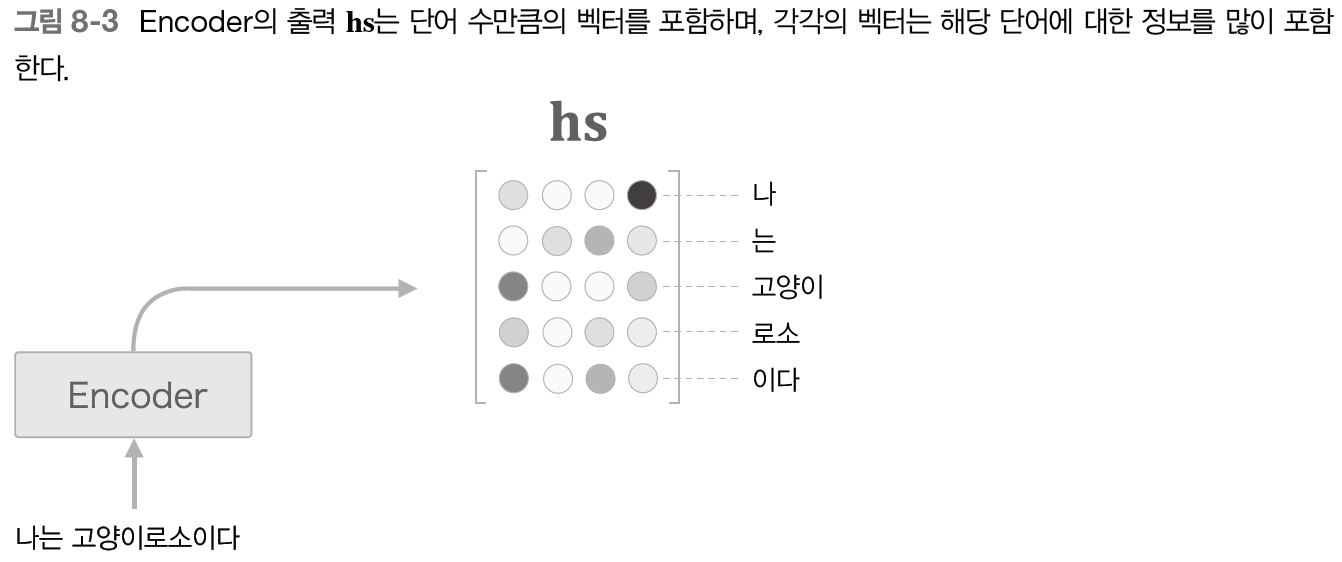

## Decoder 개선
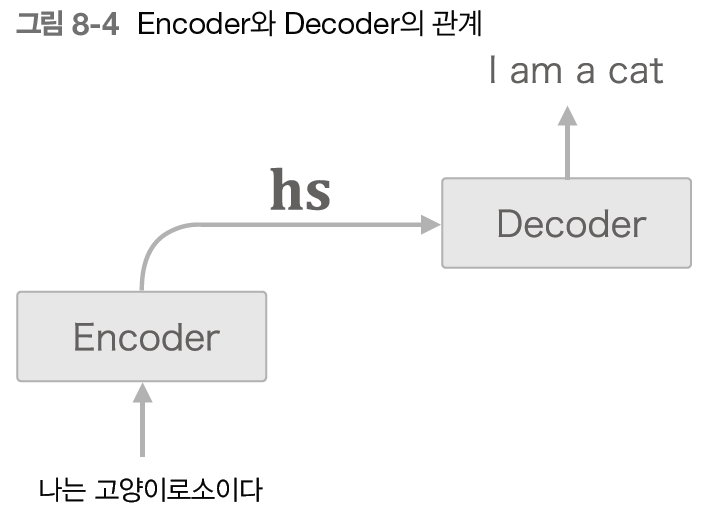

### 대응관계를 나타내는 정보 => 얼라이먼트
### 어텐션은 seq2seq + 얼라이먼트

In [3]:
import numpy as np

T, H = 5, 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5, 1).repeat(4, axis=1)
print(ar.shape)

t = hs * ar
print(t.shape)

c = np.sum(t,axis=0)
print(c.shape)

(5, 4)
(5, 4)
(4,)


In [6]:
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis=2)

t = hs* ar
print(t.shape)

c = np.sum(t, axis =1)
print(c.shape)

(10, 5, 4)
(10, 4)


In [8]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N, T, 1).repeat(H, axis=2)
        t = hs * ar
        c= np.sum(t, axis=1)
        
        self.cache = (hs, ar)
        return c
    def backward(self, dc):
        hs , ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dat = dt * hs
        dhs = dt * ar
        da = np.sum(dat, axis=2)
        
        return dhs, da

## repeat 메서드 =>다차원 배열의 원소를 복사

## Decoder 개선 2
### 각 단어의 가중치 a를 구하기
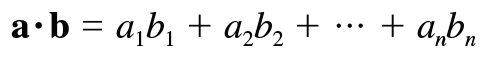
### => 내적을 이용한 벡터 유사도 구하는 방법
### => a의 원소의 총합은 1 a의 원소들은 0~1 사이의 값을 지님

In [9]:
import sys
sys.path.append("..")
from common.layers import Softmax
import numpy as np

N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
h = np.random.randn(N, H)
hr = h.reshape(N, 1, H).repeat(T, axis=1)

t = hs * hr
print(t.shape)

s = np.sum(t,axis=2)
print(s.shape)

softmax = Softmax()
a = softmax.forward(s)
print(a.shape)


(10, 5, 4)
(10, 5)
(10, 5)


In [11]:
import sys
sys.path.append('..')
from common.layers import Softmax
import numpy as np
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
h = np.random.randn(N, H)
hr = h.reshape(N, 1, H).repeat(T, axis = 1)

t = hs * hr
print(t.shape)

s = np.sum(t, axis=2)
print(s.shape)

softmax = Softmax()
a = softmax.forward(s)
print(a.shape)

(10, 5, 4)
(10, 5)
(10, 5)


# TimeAttnetion 구현

In [14]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        sefl.layers = None
        self.attnetion_weights = None
        
    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []
        
        for t in range(T):
            layer = Attnetion()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
            self.lyaers.append(layer)
            self.attention_weights.append(layer.attention_weight)
            
        return out
    def backward(sefl, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_en = np.empty_like(dout)
        
        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.bakcward(dout[:, t, :])
            dhs_enc  += dhs
            dhs_dec[:, t, :] = dh
        
        return dhs_enc, dhs_dec

In [15]:
import sys
sys.path.append('..')
from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq
from ch08.attention_layer import TimeAttention 

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs
    def backward(self,dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### 어텐션 구현
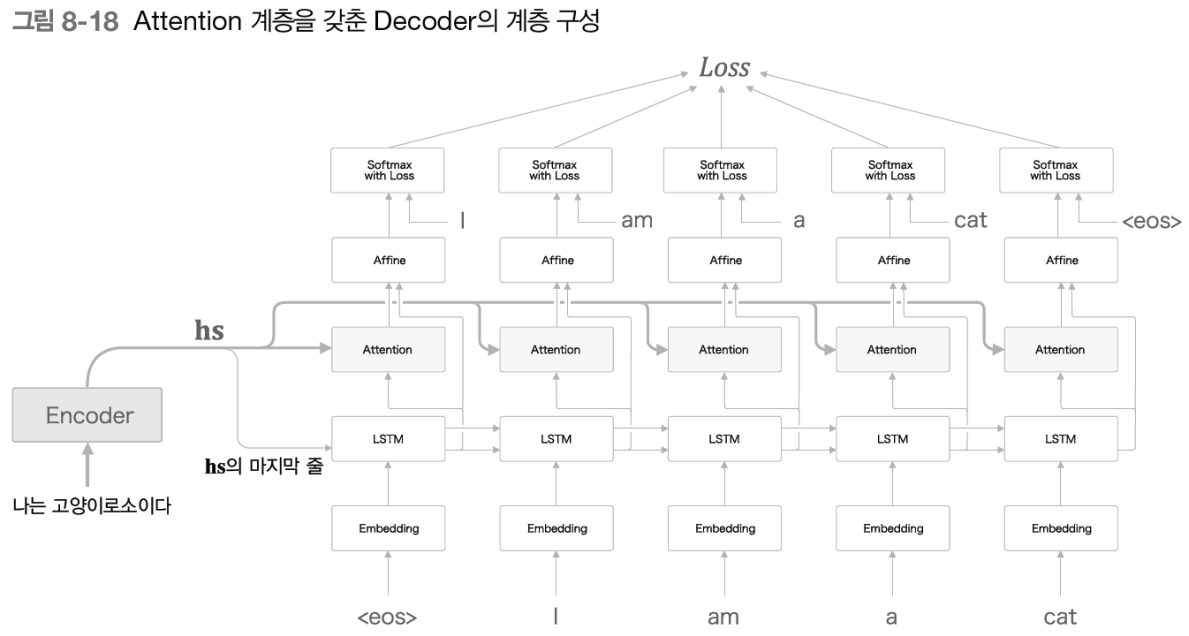

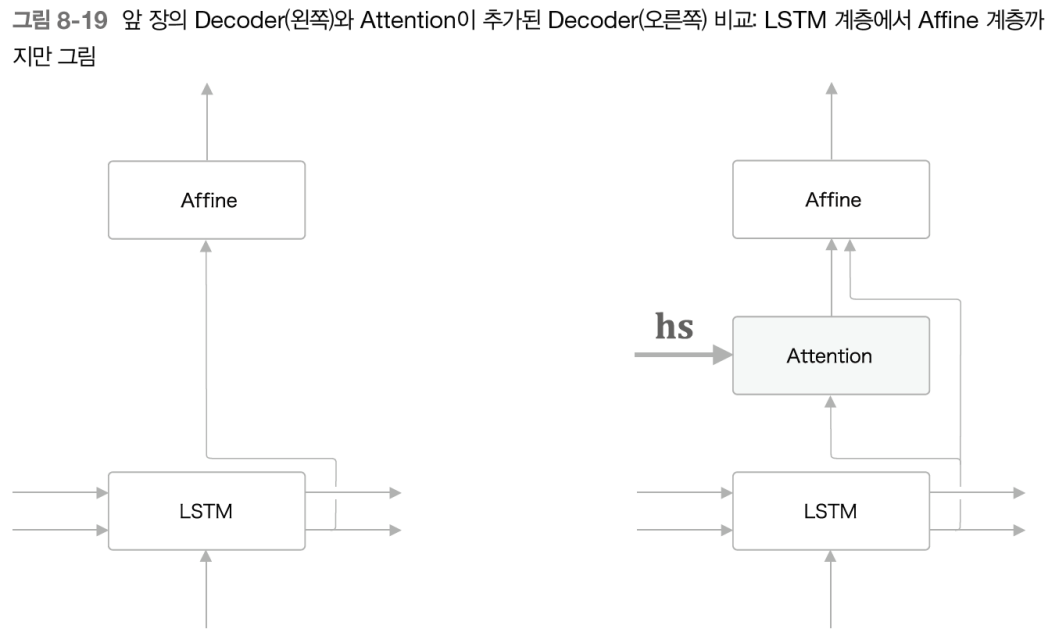

### Decoder 구현

In [17]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        embed_W = (rn(V, D)/ 100).astype('f')
        lstm_Wx = ((rn(D, 4*H))/np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros_like(4*H).astype('f')
        affine_W = (rn(2*H, V)/np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]
        
        self.params , self.grads = [], []
        for layer in layers :
            self.params += layer.params
            self.grads +=layer.grads
            
    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        dec_hs = self.lstm.fofward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis = 2)
        score = self.affine.forward(out)
        
        return score
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2
        
        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)
        
        return denc_hs
    
    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array([smaple_id]).reshape((1,1))
            
            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten)
            sampled.append(sample_id)
            
            return sampled
        
        
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
                 args = vocab_size, wordvec_size, hidden_size
                 self.encoder = AttentionEncoder(*args)
                 self.decoder = AttentionDecoder(*arge)
                 self.softmax = TimeSoftMaxWithLoss()
                 
                 self.params = self.encoder.params + self.decoder.params
                 self.grads = self.encoder.grads + self.decoder.grads
            
        
        

# 어텐션을 갖춘 seq2seq 학스

In [24]:
import sys 
sys.path.append('..')
sys.path.append('../ch07')
import numpy as np
from dataset2 import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch = 1,
               batch_size = batch_size, max_grad = max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                   id_to_char, verbose, is_reverse=True)
        
    acc = float(correct_num/ len(x_test))
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))
    
model.save_params

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 12[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 24[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 36[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 47[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 59[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 71[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 84[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 100[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 115[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 127[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 139[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 151[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 164[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 176[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 189[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 203[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 217[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
X 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
X 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
X 1978-08-11
---
Q Tuesday, November

Q Saturday, July 18, 1970      
T 1970-07-18
O 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
O 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
O 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
O 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
O 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
O 2016-11-06
---
val acc 99.920%
| 에폭 7 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 7 |  반복 21 / 351 | 시간 12[s] | 손실 0.00
| 에폭 7 |  반복 41 / 351 | 시간 25[s] | 손실 0.00
| 에폭 7 |  반복 61 / 351 | 시간 38[s] | 손실 0.00
| 에폭 7 |  반복 81 / 351 | 시간 50[s] | 손실 0.00
| 에폭 7 |  반복 101 / 351 | 시간 62[s] | 손실 0.00
| 에폭 7 |  반복 121 / 351 | 시간 74[s] | 손실 0.00
| 에폭 7 |  반복 141 / 351 | 시간 86[s] | 손실 0.00
| 에폭 7 |  반복 161 / 351 | 시간 99[s] | 손실 0.00
| 에폭 7 |  반복 181 / 351 | 시간 112[s] | 손실 0.00
| 에폭 7 |  반복 201 / 351 | 시간 125[s] | 손실 0.00
| 에폭 7 |  반복 221 / 351 | 시간 137[s] | 손실 0.00
| 에폭 7 |  반복 241 / 351 | 시간 150[s] | 손실 0.00
| 에폭 7 |  반복 261 / 351 | 시간 161[s] | 손실 0.0

<bound method BaseModel.save_params of <attention_seq2seq.AttentionSeq2seq object at 0x00000293D2C30470>>

In [26]:
import matplotlib.pyplot as plt

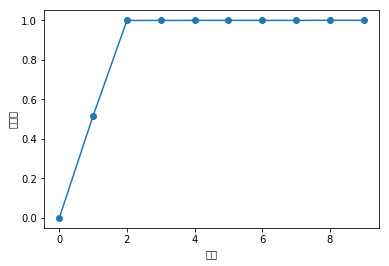

In [27]:
# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()